# Training

In [1]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torchdiffeq import odeint

cuda


In [2]:
def preprocess(data):
    a = data
    m, std = np.mean(a[:, :, 0]), np.std(a[:, :, 0])
    a[:, :, 0] = (a[:, :, 0] - m) / std 
    m, std = np.mean(a[:, :, 1]), np.std(a[:, :, 1])
    a[:, :, 1] = (a[:, :, 1] - m) / std 
    m, std = np.mean(a[:, :, 2]), np.std(a[:, :, 2])
    a[:, :, 2] = (a[:, :, 2] - m) / std 
    m, std = np.mean(a[:, :, 3]), np.std(a[:, :, 3])
    a[:, :, 3] = (a[:, :, 3] - m) / std 
    return a

In [3]:
# beats = np.load('control_beats_6.npy')
import pickle

with open('X_400_109_ori.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
def remap(x, out_min, out_max):
    in_min, in_max = np.min(x), np.max(x)
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [5]:
nindicators = 4
ncells = 576
latent_dim = 50
nhidden = 50
rnn_nhidden = 20
obs_dim = ncells * nindicators
batch_size = 16
seq_len = 1000
noise_std = 0.005
cycle_len = 500

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = preprocess(data)

    def __len__(self):
        return self.data.shape[0] - self.seq_len - 1

    def __getitem__(self, i):
        inpts = self.data[i:i+self.seq_len].copy()
        inpts[:, :, 0] = remap(inpts[:, :, 0], -1, 1)
        inpts[:, :, 1] = remap(inpts[:, :, 1], -1, 1)
        inpts[:, :, 2] = remap(inpts[:, :, 2], -1, 1)
        inpts[:, :, 3] = remap(inpts[:, :, 3], -1, 1)
        return torch.from_numpy(inpts).float()

# Define the training and test sets
train_size = int(data.shape[0] * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Create dataloaders for the training and test sets
train_dataset = TimeSeriesDataset(train_data, seq_len)
test_dataset = TimeSeriesDataset(test_data, seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset))
samp_ts = torch.from_numpy(np.linspace(0, 1, num=seq_len)).float().to(device)

42839 9960


In [7]:
X = next(iter(train_loader))
print(X.shape)

torch.Size([16, 1000, 576, 4])


In [8]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)   # outputs latent state of dim 4
        self.nfe = 0

    def forward(self, t, x): # Note that forward pass has time t as input as well, as compared to RNN where the argument would be no. of neurons in hidden layers!
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

In [9]:
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) # Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self, batch_size=None):
        if batch_size is None:
            return torch.zeros(self.nbatch, self.nhidden)
        else:
            return torch.zeros(batch_size, self.nhidden)
     

In [10]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out
     

In [11]:
#same func as in last colab, we'll use this in training to calculate and show loss
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [12]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

In [13]:
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
#params

In [14]:
optimizer = optim.Adam(params, lr=0.01)
loss_meter = RunningAverageMeter()

In [15]:
def log_normal_pdf(x, mean, logvar):
    result = -.5 * (logvar + (x - mean) ** 2. / torch.exp(logvar))
    return result

  
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [ ]:
import time
start_time = time.time()

niters = 2
min_loss = 100000000
scalar = 100000
for itr in tqdm(range(1, niters+1)):
    for bi, samp_trajs in enumerate(train_loader):
        # Move input to device
        b_, seq_l, _, _ = samp_trajs.size()
        samp_trajs = samp_trajs.to(device)  # (16, seq_len, 576, 4)

        # Zero gradients
        optimizer.zero_grad()
        
        # backward in time to infer q(z_0)
        h = rec.initHidden(batch_size=b_).to(device) # for recurrent nn
        for t in reversed(range(seq_l)):
            obs = samp_trajs[:, t, :]
            obs = obs.view(b_, ncells*nindicators)
            out, h = rec.forward(obs, h) # init forward pass to create batch_y0 for training

        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean  # (N, 50)


        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
        pred_x = dec(pred_z)  #decoder
        pred_x = pred_x.view(b_, seq_l, ncells, nindicators)


        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
        loss = torch.mean(-logpx + analytic_kl, dim=0)

        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        print(loss_meter.avg)

        if loss_meter.avg/scalar < min_loss:
            min_loss = loss_meter.avg/scalar
            index = np.random.randint(b_)

            plt.figure()
            plt.scatter(pred_x[index,:, :, 0].detach().cpu().numpy(), samp_trajs[index,:, :, 0].detach().cpu().numpy()) #1000
            plt.show()

            plt.figure()
            plt.plot(samp_trajs[index,:, :, 0].detach().cpu().numpy())
            plt.plot(pred_x[index,:, :, 0].detach().cpu().numpy())
            plt.show()

            print('Epoch: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

            # Specify a path to save to
            PATH = f"0330/lstm_ar_usingbench2-{itr}-{bi}-VAEnonoise.pt"

            torch.save({
                        'func_dict': func.state_dict(),
                        'rec_dict': rec.state_dict(),
                        'dec_dict': dec.state_dict()
                        }, PATH)

end_time = time.time()

total_time = end_time - start_time
print(f"Total running time: {total_time} seconds.")

# forecasting

In [25]:
s = 500  # random starting time in test time span

In [26]:
import time

start_time = time.time()

# load and prediction ODE 
nindicators = 4
ncells = 576
latent_dim = 50
nhidden = 50
rnn_nhidden = 20
obs_dim = ncells * nindicators
batch_size = 16
seq_len = 1000
noise_std = 0.005
cycle_len = 500


def remap(x, out_min, out_max):
    in_min, in_max = np.min(x), np.max(x)
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min


class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)   # outputs latent state of dim 4
        self.nfe = 0

    def forward(self, t, x): # Note that forward pass has time t as input as well, as compared to RNN where the argument would be no. of neurons in hidden layers!
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out
    
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) # Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self, batch_size=None):
        if batch_size is None:
            return torch.zeros(self.nbatch, self.nhidden)
        else:
            return torch.zeros(batch_size, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    
PATH = "0329/lstm_ar_usingbench2-2-2355-VAEnonoise.pt"

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

checkpoint = torch.load(PATH)
func.load_state_dict(checkpoint['func_dict'])
rec.load_state_dict(checkpoint['rec_dict'])
dec.load_state_dict(checkpoint['dec_dict'])

func.eval()
rec.eval()
dec.eval()


# Test the model
future_n_cycle = 2
with torch.no_grad():
    h = torch.zeros(1, rnn_nhidden).to(device)
    inpt_data = test_data[s:s+cycle_len*future_n_cycle].copy()
    inpt_data[:, :, 0] = remap(inpt_data[:, :, 0], -1, 1)
    inpt_data[:, :, 1] = remap(inpt_data[:, :, 1], -1, 1)
    inpt_data[:, :, 2] = remap(inpt_data[:, :, 2], -1, 1)
    inpt_data[:, :, 3] = remap(inpt_data[:, :, 3], -1, 1)
    inpts = torch.from_numpy(inpt_data).float().unsqueeze(0).to(device)
    print(inpts.size())

    # warm-up
    for t in reversed(range(seq_len)):
        obs = inpts[:, t, :]
        obs = obs.view(1, ncells*nindicators)
        out, h = rec.forward(obs, h) # init forward pass to create batch_y0 for training

    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    future_ts = torch.from_numpy(np.linspace(0, future_n_cycle/2, num=cycle_len*future_n_cycle)).to(device)

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, future_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)  #decoder
    pred_x = pred_x.view(1, -1, ncells, nindicators)
    print(pred_x.size())
    pred_x = pred_x.cpu().detach().numpy()
    
end_time = time.time()

total_time = end_time - start_time
print(f"Total running time: {total_time} seconds.")

torch.Size([1, 1000, 576, 4])
torch.Size([1, 1000, 576, 4])
Total running time: 1.9428365230560303 seconds.


/tmp/ipykernel_2942/3495800825.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


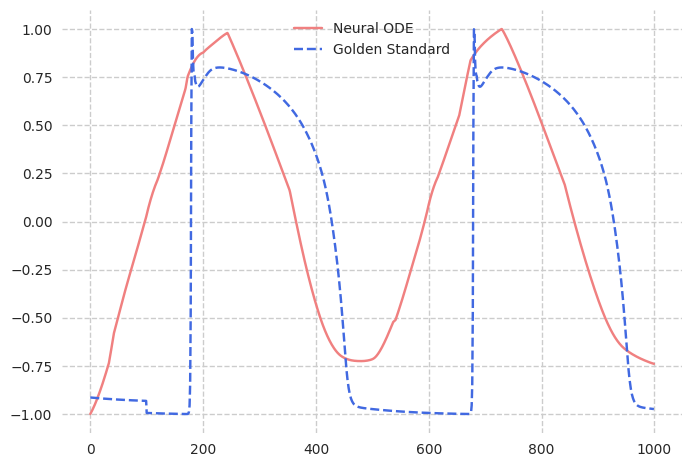

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
plt.style.use("seaborn")
sns.set_style("white")
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})



cell = 84
rg = 1000
plt.figure()
plt.plot(range(rg), remap(pred_x[0, :rg, cell, 0], -1, 1), label="Neural ODE", color="lightcoral")
plt.plot(range(rg), remap(preprocess(test_data)[s:s+rg, cell, 0], -1, 1), label="Golden Standard", color="royalblue", linestyle="dashed")
plt.legend()
plt.show()